**<center> IDS SYSTEM BASED ON NEURAL NETWORK ANOMALY DETECTION </center>**
**<center> CICIDS2017 Dataset </center>**

In [164]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler, PowerTransformer, Normalizer
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score, recall_score, precision_score, matthews_corrcoef, f1_score
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.python.keras.utils import losses_utils
from tensorflow.keras.utils import to_categorical
import tensorflow_addons as tfa

from imblearn.over_sampling import SMOTE

from scipy.interpolate import make_interp_spline
import time
from datetime import datetime

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

sns.set_style('dark')
pd.set_option('display.max_columns', None)
plt.rcParams.update({'font.size': 18})

**<center> PREPROCESSING STAGE </center>**

Defined functions:

<font color=#323DAA> 1. choose_dataset() </font>

It takes 2 arguments: <ins>num</ins> (0...3) - dataset type;  <ins>path of dataset location</ins>\
It returns <ins>data in csv format</ins> and <ins>the name of chosen dataset</ins> for further simplifying plot saving 

<font color=#323DAA> 2. distribution_plot() </font>

It is a plotting function that shows object distribution by class. It has two options in order to process pandas or numpy input

It takes 3 arguments: <ins>data</ins>;  <ins>data type</ins>, <ins>saving option</ins>

<font color=#323DAA> 3. pca_scaling_plot() </font>

It is plotting and preprocessing function that shows spatial distribution of objects compressed to two features by PCA algorithm before and after scaling process. 

It takes 4 arguments: <ins>X</ins>;  <ins>y</ins>, <ins>usage method</ins>, <ins>saving option</ins>

It returns scaled objects and fits pca algorithm to be used later

<font color=#323DAA> 4. pca_oversampling_plot() </font>

It is plotting and preprocessing function that shows spatial distribution of objects compressed to two features by fitted PCA algorithm before and after oversampling process. 

It takes 4 arguments: <ins>X</ins>;  <ins>y</ins>, <ins>sampling algorithm</ins>, <ins>saving option</ins>

It returns oversampled objects

<font color=#323DAA> 5. zero_std_cols() </font>

This is a function that searches uninformative columns in terms of zero variance

It takes 1 argument: <ins>data</ins>

It returns columns to be dropped

<font color=#323DAA> 6. preprocessing() </font>

It is a preprocessing system which transforms input data depending on the method of its work. 

The methods are classified into 3 types:

- <ins>train_test_val</ins>, which is needed for pca algotithm and scaling functions fitting. It also splits the  dataset into three components-subsets. It should be launched first
 
- <ins>test</ins>, which uses already fitted scaling functions in order to process test data to the same distribution. It also uses fitted pca for visualization purposes.
    
- <ins>test_manual_label</ins>, which can be used for type I and type II errors checking. In that case we have some unlabelled data (for example captured network data from a personal computer while surfing secure websites) and we sure that these objects have BENIGN label (normal state). Basically labelled malicious data can be downloaded and checked by this method as well.
    
Note that test data features should not lie outside the training data range, otherwise training data should be updated for the purpose of correct scaling.
Also the dataset has limited amount of classes so ideally it is necessary to expand the number of classes.

Function takes 4 arguments: <ins>input data</ins>;  <ins>scaling function</ins>, <ins>method</ins>, <ins>show plots option</ins>, <ins>plot saving option</ins>, <ins>label (for test manual label method)</ins>

Function returns preprocessed data (subsets) depending on the applyed method

In [114]:
def choose_dataset(num, path):
    datasets = {0: 'small' ,
                1: 'medium',
                2: 'final' ,
                3: 'full',
                4: 'captured',
                5: 'pcap_Flow1'}

    dataset = datasets[num]
    data = pd.read_csv(path + dataset + '.csv')
    return data, dataset

def distribution_plot(data, transformed = False, save = False):
    fig, ax = plt.subplots(figsize = (20, 7.5))

    if transformed:
        data.Label = LE.inverse_transform(data.Label)
        plt.title('Distribution by class after data preprocessing\n Logarithmic scale', fontsize = 18)
    else:
        plt.title('Distribution by class before data preprocessing\n Logarithmic scale', fontsize = 18)

    dif = pd.DataFrame({'Value':np.log10(data.Label.value_counts()),'Class':data.Label.value_counts().index.tolist()})

    plot = sns.barplot(x = 'Class', y = 'Value', data = dif)

    for bar in plot.patches:
        plot.annotate(str(round(10 ** bar.get_height()/len(data)*100, 3))+'%',
        (bar.get_x() + bar.get_width() / 2., bar.get_height()),
        ha = 'center', va = 'center',
        xytext = (0, 9),
        textcoords = 'offset points', fontsize = 14)

    ax.set_xlabel('\nClass')
    ax.set_ylabel('Value')
    plt.xticks(rotation=90, fontsize=14)
    plt.tight_layout()
    if save:
        if transformed:
            plt.savefig(dataset + '_class_dist_transformed.png', dpi = 100, format='png')
        else:
            plt.savefig(dataset + '_class_dist.png', dpi = 100, format='png')
    plt.show()
    
def pca_scaling_plot(X, y, method, save = False):

    global pca

    pca = PCA(n_components = 2)

    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 7.5))
    plt.suptitle('\n  Scaling process (PCA)', fontsize = 18)

    result = pca.fit_transform(X)
    axis1_init = result[:, 0]
    axis2_init = result[:, 1]
    
    if method == 'train_test_val' or method == 'test_manual_label':
        data_init = pd.DataFrame({'x':axis1_init, 'y':axis2_init, 'Label': LE.inverse_transform(y.Label.array)})
    else:
        data_init = pd.DataFrame({'x':axis1_init, 'y':axis2_init, 'Label': 'Unknown'})

    del axis1_init, axis2_init, result

    plot = sns.scatterplot(data = data_init, x = 'x', y = 'y', hue = 'Label', s = 20, palette = 'Paired', linewidth = 0.2, ax = ax[0])
    plot.legend(loc = 4)
    del data_init

    X = scaler.transform(X)
    pca.fit(X)
    result = pca.transform(X)
    axis1_new = result[:, 0]
    axis2_new = result[:, 1]
    if method == 'train_test_val' or method == 'test_manual_label':
        data_new  = pd.DataFrame({'x':axis1_new, 'y':axis2_new, 'Label': LE.inverse_transform(y.Label.array)})
    else:
        data_new  = pd.DataFrame({'x':axis1_new, 'y':axis2_new, 'Label': 'Unknown'})

    del axis1_new, axis2_new, result

    sns.scatterplot(data = data_new, x = 'x', y = 'y', hue = 'Label', s = 20,  palette = 'Paired', linewidth = 0.2, ax = ax[1])

    ax[0].set_xlabel('X1')
    ax[0].set_ylabel('X2')
    
    ax[1].set_xlabel('X1')
    ax[1].legend('')
    ax[1].set_ylabel('')

    del data_new

    fig.tight_layout()
    if save == True:
        plt.savefig(dataset + '_scaling.png', dpi = 400, format='png')
    plt.show()

    return X

def pca_oversampling_plot(X, y, alg, save = False):

    list_colors = list(sns.color_palette('Pastel1', n_colors = 12).as_hex())
    list_colors.insert(11, '#0188E0')
    list_colors[1]       = '#81CDE3'
    list_colors[12]      = '#FF3D1F'

    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 7.5))
    plt.suptitle('\n  Oversampling process (PCA)', fontsize = 18)

    result = pca.transform(X)
    axis1_init = result[:, 0]
    axis2_init = result[:, 1]
    data_init = pd.DataFrame({'x':axis1_init, 'y':axis2_init, 'Label': LE.inverse_transform(y.Label.array)})
    del axis1_init, axis2_init, result
    order = LE.inverse_transform(y.Label.value_counts().index.tolist())
    sns.scatterplot(data = data_init, x = 'x', y = 'y', hue = 'Label', hue_order = order, sizes = np.hstack(np.array([np.repeat(20,11),30,30])), palette = list_colors, linewidth = 0.2, ax = ax[0]).legend(loc=1)
    sns.scatterplot(data = data_init.loc[(data_init.Label == 'Infiltration') | (data_init.Label == 'Heartbleed')], x = 'x', y = 'y', hue = 'Label', legend = False, hue_order = order, sizes = np.hstack(np.array([np.repeat(20,11),30,30])), palette = list_colors, linewidth = 0.2, ax = ax[0])

    del data_init

    X, y = alg.fit_resample(X, y)
    result = pca.transform(X)
    axis1_new = result[:, 0]
    axis2_new = result[:, 1]
    data_new  = pd.DataFrame({'x':axis1_new, 'y':axis2_new, 'Label': LE.inverse_transform(y.Label.array)})
    del axis1_new, axis2_new, result
    sns.scatterplot(data = data_new, x = 'x', y = 'y', hue = 'Label', hue_order = order, s = 20, palette = list_colors, linewidth = 0.2, legend = True, ax = ax[1])
    del data_new
    
    h,l = ax[1].get_legend_handles_labels()

    ax[1].legend(np.array(h)[[11,12]],np.array(l)[[11,12]])
    ax[0].set_xlabel('X1')
    ax[0].set_ylabel('X2')
    ax[1].set_xlabel('X1')
    ax[1].set_ylabel('')
    fig.tight_layout()
    if save == True:
        plt.savefig(dataset + '_smote.png', dpi = 400, format='png')
    plt.show()
    return X,y

def zero_std_cols(data):
    del_cols = []
    for i in range(data.shape[1]-1):
        if np.std(data[data.columns[i]]) == 0:
            del_cols.append(i)
    return del_cols

def preprocessing(data, scaling_func, method = 'train_test_val', show_plots = False, save_plots = False, label = None): # method: train_test_val, test, test_manual_label

    if method == 'train_test_val' and show_plots == True or show_plots == 'dist': #--- show distribution by class ---#
        distribution_plot(data, transformed = False, save = save_plots)

    #--- remove nans & infs ---#
    data.loc[data['Flow Bytes/s'] == np.inf, 'Flow Bytes/s'] = np.nan
    data.loc[data['Flow Packets/s'] == np.inf, 'Flow Packets/s'] = np.nan
    data = data.dropna()

    if method == 'test' or method == 'test_manual_label':
        data = data.drop(data.columns[[0,1,2,3,4,5,6]], axis=1)
        data.Label = label
    else:
        #--- in order to remove cols with zero std ---#
        global del_cols
        del_cols = zero_std_cols(data = data)

    data = data.drop(data.columns[del_cols], axis = 1)

    #--- data splitting ---#
    X = data[data.columns[:-1]]

    if method == 'train_test_val':
        y = data[data.columns[-1]].astype(str)
        global LE
        LE = LabelEncoder()
        LE.fit(y)
        X = X.drop(columns = ['Destination Port', 'Fwd Header Length.1'], axis = 1)
        y = pd.DataFrame(LE.transform(y), index = y.index, columns = ['Label'])

    elif method == 'test_manual_label':
        y = data[data.columns[-1]].astype(str)
        y = pd.DataFrame(LE.transform(y), index = y.index, columns = ['Label'])

    del data

    if method == 'train_test_val':
        global scaler
        scaler = scaling_func
        scaler.fit(X)

        if show_plots == True or show_plots == 'scaling':  #--- show non-normalized features ---#
            pca_scaling_plot(X = X, y = y, method = method, save = save_plots)

        X = scaler.transform(X)

        sampler = SMOTE(sampling_strategy = {8: 1956, 9: 1956}, random_state = 0, n_jobs = -1, k_neighbors=10)

        if show_plots == True or show_plots == 'smote':  #--- show init+sampled objects ---#
            X,y = pca_oversampling_plot(X = X, y = y, alg = sampler, save = save_plots)
        else:
            X,y = sampler.fit_resample(X,y)

        if show_plots == True or show_plots == 'dist':  #--- show distribution by class ---#
            distribution_plot(pd.concat([pd.DataFrame(X),y], axis = 1), transformed = True, save = save_plots)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, stratify = y, random_state = 0)
        X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, stratify = y_test, random_state = 0)
        y_train, y_test, y_val = y_train.values, y_test.values, y_val.values

        return {'X_train': X_train,'X_test': X_test,'X_val': X_val,'y_train': y_train,'y_test': y_test,'y_val': y_val}

    elif method == 'test_manual_label':
        if show_plots == True or show_plots == 'scaling':  #--- show normalized features ---#
            X = pca_scaling_plot(X = X, y = y, method = method, save = save_plots)
        else:
            X = scaler.transform(X)
    else:
        if show_plots == True or show_plots == 'scaling':  #--- show normalized features ---#
            X = pca_scaling_plot(X = X, y = None, method = method, save = save_plots)
        else:
            X = scaler.transform(X)


    if method == 'test_manual_label':
        return {'X_test': X, 'y_test': y.values}

    if method == 'test':
        return {'X_test': X}

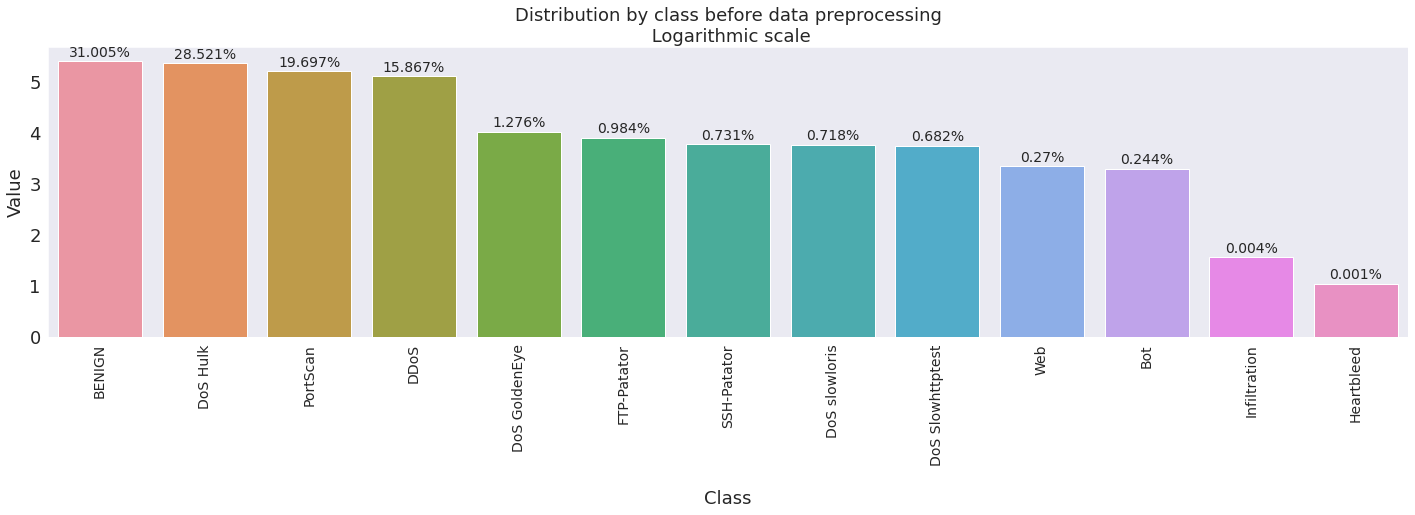

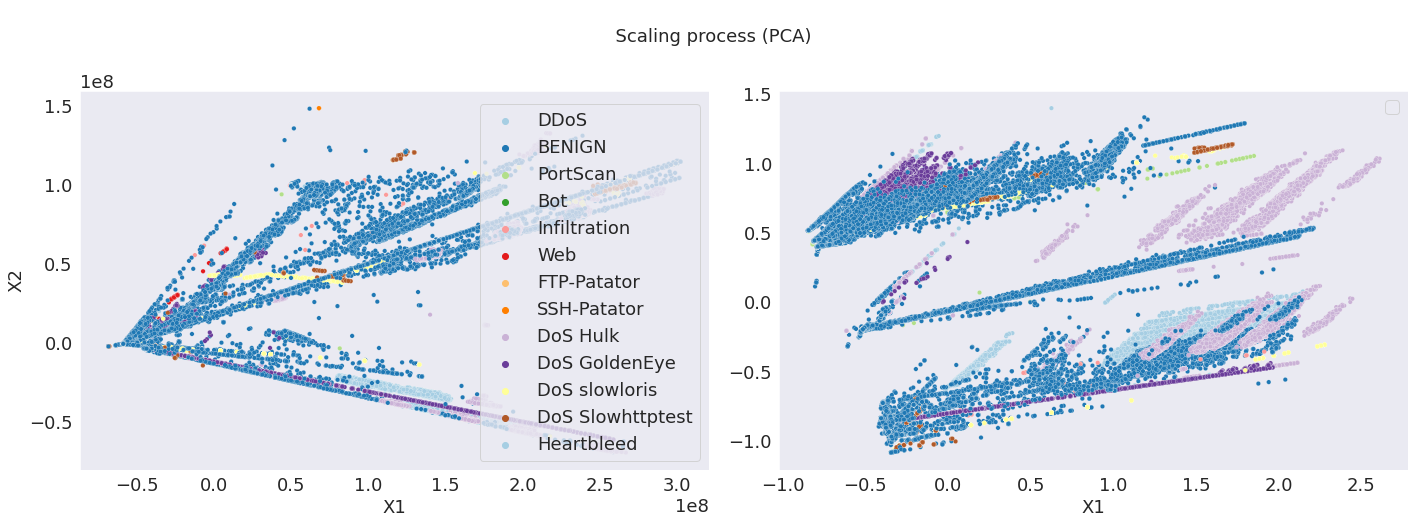

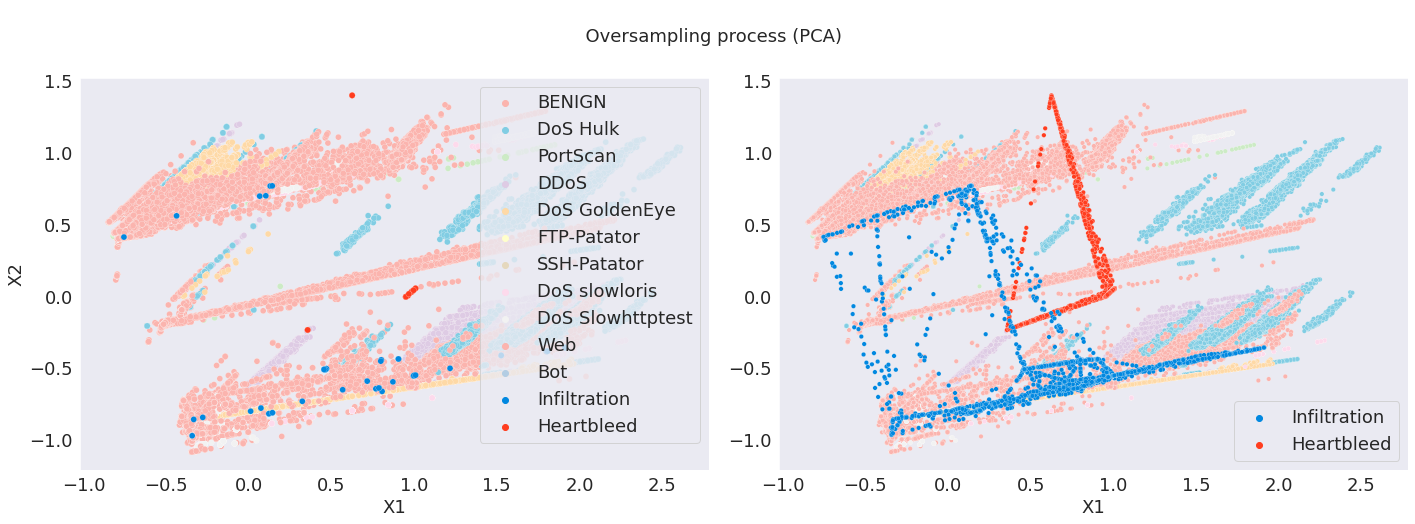

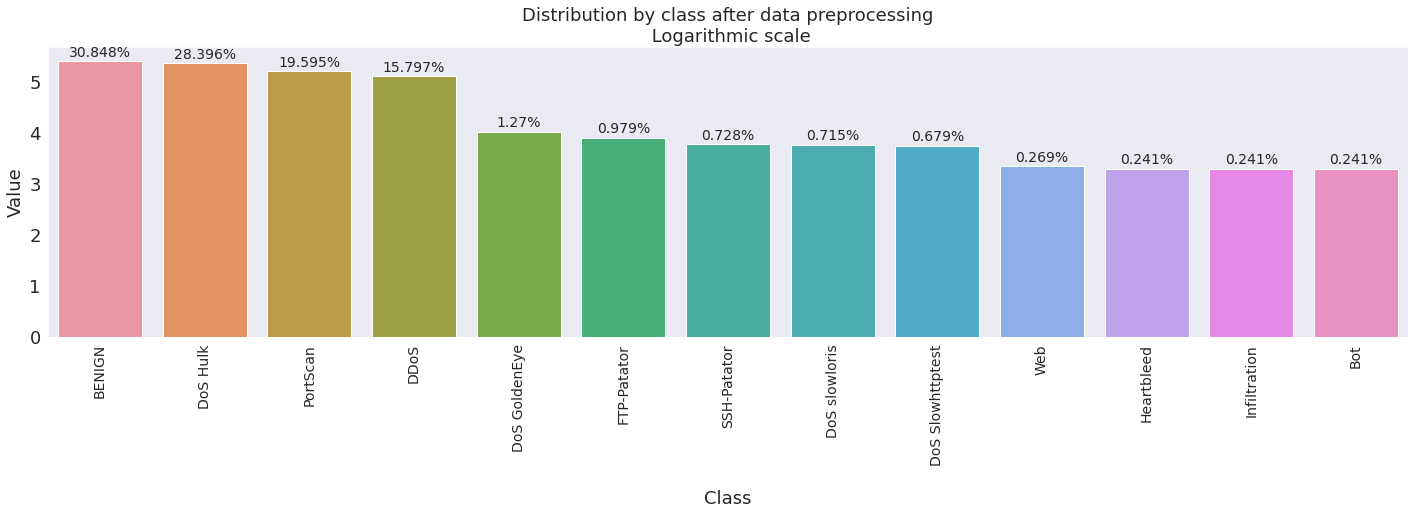

In [6]:
data, dataset = choose_dataset(2, path = '../Data/Data_Thesis/')
scaler = MinMaxScaler()
output = preprocessing(data = data, method = 'train_test_val', scaling_func = scaler, show_plots = True)

locals().update(output) # X_train, X_test, X_val, y_train, y_test, y_val  -  as viriables

**<center> NEURAL NETWORK BUILDING </center>**

Defined functions:

1. learning()

The idea is to use two different teaching methods such as: 

 - <ins>original learning method</ins>
 
 - <ins>custom learning method</ins>, which has adaptive learning rate depending on epochs

It takes 7 arguments: <ins>learning rate</ins>, <ins>optimizer</ins>, <ins>method</ins>, <ins>epochs</ins>, <ins>class_weights</ins>, <ins>callback</ins>, <ins>verbose</ins>

It returns <ins>results</ins> (train/val  accuracy/loss) and <ins>trained model</ins>

2. smooth()

It's used to get smoothed curve of model's loss and accuracy by interpolate method

It takes 3 arguments: <ins>y</ins>, <ins>epochs</ins>, <ins>n</ins> (sampling parameter)

It returns two coordinates <ins>x</ins> (epochs) and <ins>y</ins> (values)

3. plot_loss_acc()

It's used to graph loss and accuracy plots

It takes 6 arguments: <ins>history</ins>, <ins>epochs</ins>, <ins>custom learning rate indicator</ins>, <ins>smoothing switcher</ins>, <ins>saving option</ins>, <ins>validation line</ins> (shows best model's result)

4. confusion_matrix_plot(y_test, y_pred, path = '', save = True)

It's used to plot confusion matrix

It takes 4 arguments: <ins>y_test</ins>, <ins>y_pred</ins>, <ins>saving path</ins>, <ins>saving option</ins>

5. metrics_score()

It's used to show model's classification quality by testing on different metrics such as:

- accuracy
- balanced accuracy
- matthews corrcoef
- f1
- recall
- precision

It takes 3 arguments: <ins>y_pred</ins>, <ins>y_test</ins>, <ins>average type</ins> (micro/macro)

In [41]:
# class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(LE.inverse_transform(y_train.ravel())), y = LE.inverse_transform(y_train.ravel()))
# class_weights = dict(enumerate(class_weights.flatten(), 0))
# callback = [tf.keras.callbacks.ModelCheckpoint(filepath = '', save_weights_only = True, verbose = 1)]

def learning(learning_rate, optimizer = tf.keras.optimizers.Adam(), method = 'original', epochs = 15, class_weights = None, callback = None, verbose = True):
    if method == 'original':
        optimizer.learning_rate.assign(learning_rate)
        model.compile(optimizer = optimizer, loss = tf.keras.losses.CategoricalCrossentropy(), metrics = tf.keras.metrics.CategoricalAccuracy(), run_eagerly = True)
        #loss = tf.keras.losses.KLDivergence(reduction = losses_utils.ReductionV2.AUTO)
        history = model.fit(X_train, to_categorical(y_train), validation_data = (X_val, to_categorical(y_val)), epochs = epochs, class_weight = class_weights, batch_size = 256, callbacks = callback, verbose = verbose)
        return history, model
    if method == 'custom':
        result = {'loss': [], 'val_loss': [], 'categorical_accuracy': [], 'val_categorical_accuracy': []}
        for i in range(int(epochs/5)):
            if i < 3:
                optimizer.learning_rate.assign(learning_rate/(10**i))
                model.compile(optimizer = optimizer, loss = tf.keras.losses.CategoricalCrossentropy(), metrics=tf.keras.metrics.CategoricalAccuracy(), run_eagerly = True)
            else:
                optimizer.learning_rate.assign(learning_rate/(10**2))
                model.compile(optimizer = optimizer, loss = tf.keras.losses.CategoricalCrossentropy(), metrics=tf.keras.metrics.CategoricalAccuracy(), run_eagerly = True)
            history  = model.fit(X_train, to_categorical(y_train), validation_data = (X_val, to_categorical(y_val)), epochs = 5, class_weight = class_weights, batch_size = 256, callbacks = callback, verbose = verbose)
            result['loss'].append(history.history['loss'])
            result['val_loss'].append(history.history['val_loss'])
            result['categorical_accuracy'].append(history.history['categorical_accuracy'])
            result['val_categorical_accuracy'].append(history.history['val_categorical_accuracy'])
        return result, model
    
def smooth(y, epochs, n = 100):
    x = np.arange(1, epochs + 1)
    x_smooth = np.linspace(x.min(), x.max(), n)
    spl = make_interp_spline(x, y, k = 3)
    y_smooth = spl(x_smooth)
    return x_smooth, y_smooth

def plot_loss_acc(history, epochs, custom_LR = False, smoothing = True, save = True, val_line = True):
    if custom_LR:
        acc = np.array(history['categorical_accuracy']).flatten()
        val_acc = np.array(history['val_categorical_accuracy']).flatten()
        loss = np.array(history['loss']).flatten()
        val_loss = np.array(history['val_loss']).flatten()
    else:
        acc = history.history['categorical_accuracy']
        val_acc = history.history['val_categorical_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

    x = np.arange(1, epochs + 1)

    if smoothing:
        x, loss = smooth(loss, epochs = epochs)
        x, val_loss = smooth(val_loss, epochs = epochs)
        x, acc = smooth(acc, epochs = epochs)
        x, val_acc = smooth(val_acc, epochs = epochs)

    fig, axes=plt.subplots(1,2,figsize=(20,7.5))

    plt.suptitle('\n  Loss & Accuracy', fontsize = 18)

    sns.lineplot(x = x, y = loss, ax = axes[0])
    sns.lineplot(x = x, y = val_loss, ax = axes[0])
    sns.lineplot(x = x, y = acc, ax = axes[1])
    sns.lineplot(x = x, y = val_acc, ax = axes[1])

    axes[0].axhline(loss.min(), ls = '--', color = 'black', linewidth = 0.5)
    axes[1].axhline(acc.max(), ls = '--', color = 'black', linewidth = 0.5)
    axes[0].text(0.03*epochs, loss.min(), str(round(loss.min(),3)), fontsize = 14, va='center', ha='center', color = 'red', backgroundcolor = '#EAEAF2')
    axes[1].text(0.03*epochs, acc.max(), str(round(acc.max(),3)), fontsize = 14, va='center', ha='center', color = 'red', backgroundcolor = '#EAEAF2')

    axes[0].set_xlabel('Epochs'), axes[1].set_xlabel('Epochs'), axes[0].set_ylabel('Loss'), axes[1].set_ylabel('Accuracy')
    axes[0].set_xlim(-0.5)
    axes[1].set_xlim(-0.5)

    axes[0].legend(('train loss', 'validation loss'))
    axes[1].legend(('train categorical accuracy', 'validation categorical accuracy'), loc = 4)

    if val_line:
        axes[0].axhline(val_loss[-1], ls = '--', color = 'black', linewidth = 0.5)
        axes[1].axhline(val_acc[-1], ls = '--', color = 'black', linewidth = 0.5)
        axes[0].text(0.03*epochs, val_loss[-1], str(round(val_loss[-1],3)), fontsize = 14, va='center', ha='center', color = 'red', backgroundcolor = '#EAEAF2')
        axes[1].text(0.03*epochs, val_acc[-1], str(round(val_acc[-1],3)), fontsize = 14, va='center', ha='center', color = 'red', backgroundcolor = '#EAEAF2')

    fig.tight_layout()

    if save:
        plt.savefig('Latex/Diploma_new/Images/' + dataset + '.png', dpi = 200, format='png')
    plt.show()
    
def confusion_matrix_plot(y_test, y_pred, save = True):
    cm = confusion_matrix(y_test, y_pred)
    fig, ax=plt.subplots(figsize = (20,7.5))
    plt.title('\n  Confusion Matrix', fontsize = 18)
    x_y_labels = np.unique(LE.inverse_transform(y_pred.ravel())) #y_test
    sns.heatmap(cm, annot = True, cmap = 'Blues', fmt = 'g', xticklabels = x_y_labels, ax = ax, yticklabels = x_y_labels, annot_kws={"size": 14}, cbar=False)
    ax.set_ylabel("True Class")
    ax.set_xlabel("Predicted Class")
    ax.tick_params(labelsize=14)
    fig.tight_layout()
    if save:
        plt.savefig(dataset + 'cm.png', dpi = 200, format = 'png')
    plt.show()
    
def metrics_score(y_pred, y_test, average = 'micro'):
    print(np.round(accuracy_score(y_pred, y_test), 5), ' | accuracy_score')
    print(np.round(balanced_accuracy_score(y_pred, y_test), 5), ' | balanced_accuracy_score', )
    print(np.round(matthews_corrcoef(y_pred, y_test), 5), ' | matthews_corrcoef')
    print(np.round(f1_score(y_pred, y_test, average = average), 5), ' | f1_score')
    print(np.round(recall_score(y_pred, y_test, average = average), 5), ' | recall_score')
    print(np.round(precision_score(y_pred, y_test, average = average), 5), ' | pecicion_score')


Initial hyperparameters checking

- 1st layer - 100 neurons
- 2nd layer - 50 neurons
- Activation functions: ReLU
- Learning rate - 0.001
- Epochs - 10
- Regularization - Batch Normalization
- Optimizer - Adam
- Batch Size - 256

Epoch 1/5
2850/2850 [==============================] - 62s 22ms/step - loss: 0.1400 - categorical_accuracy: 0.9600 - val_loss: 0.0765 - val_categorical_accuracy: 0.9756
Epoch 2/5
2850/2850 [==============================] - 59s 21ms/step - loss: 0.0785 - categorical_accuracy: 0.9745 - val_loss: 0.0717 - val_categorical_accuracy: 0.9752
Epoch 3/5
2850/2850 [==============================] - 71s 25ms/step - loss: 0.0726 - categorical_accuracy: 0.9763 - val_loss: 0.0767 - val_categorical_accuracy: 0.9743
Epoch 4/5
2850/2850 [==============================] - 61s 21ms/step - loss: 0.0697 - categorical_accuracy: 0.9769 - val_loss: 0.1001 - val_categorical_accuracy: 0.9720
Epoch 5/5
2850/2850 [==============================] - 59s 21ms/step - loss: 0.0673 - categorical_accuracy: 0.9778 - val_loss: 0.0760 - val_categorical_accuracy: 0.9770
Epoch 1/5
2850/2850 [==============================] - 59s 21ms/step - loss: 0.0608 - categorical_accuracy: 0.9798 - val_loss: 0.0582 - val_categorical_acc

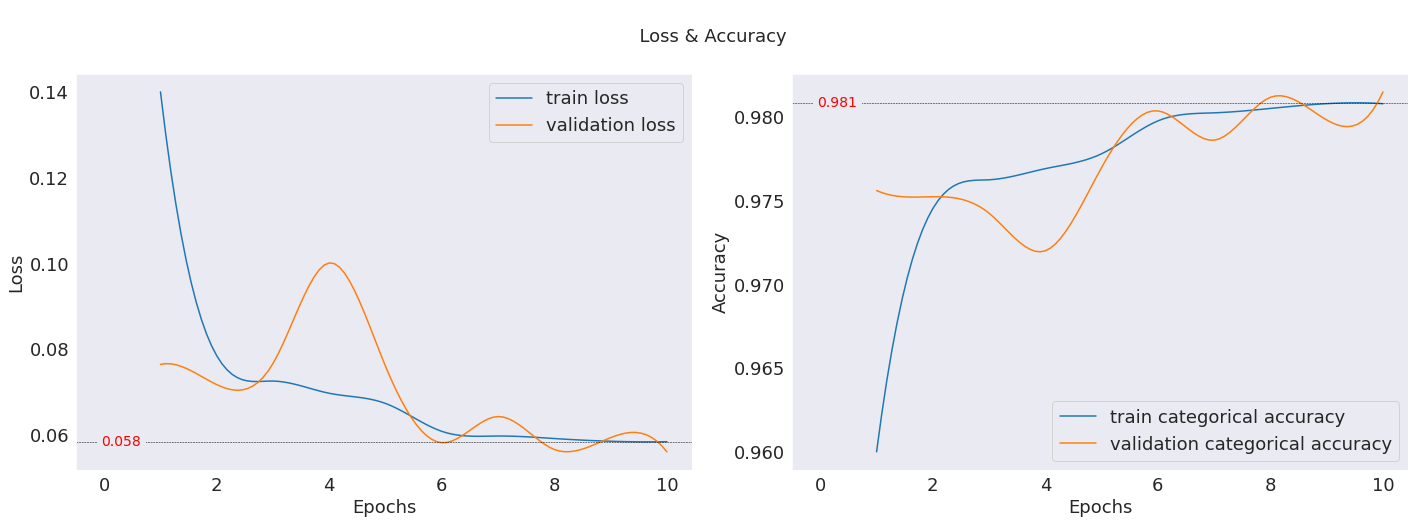

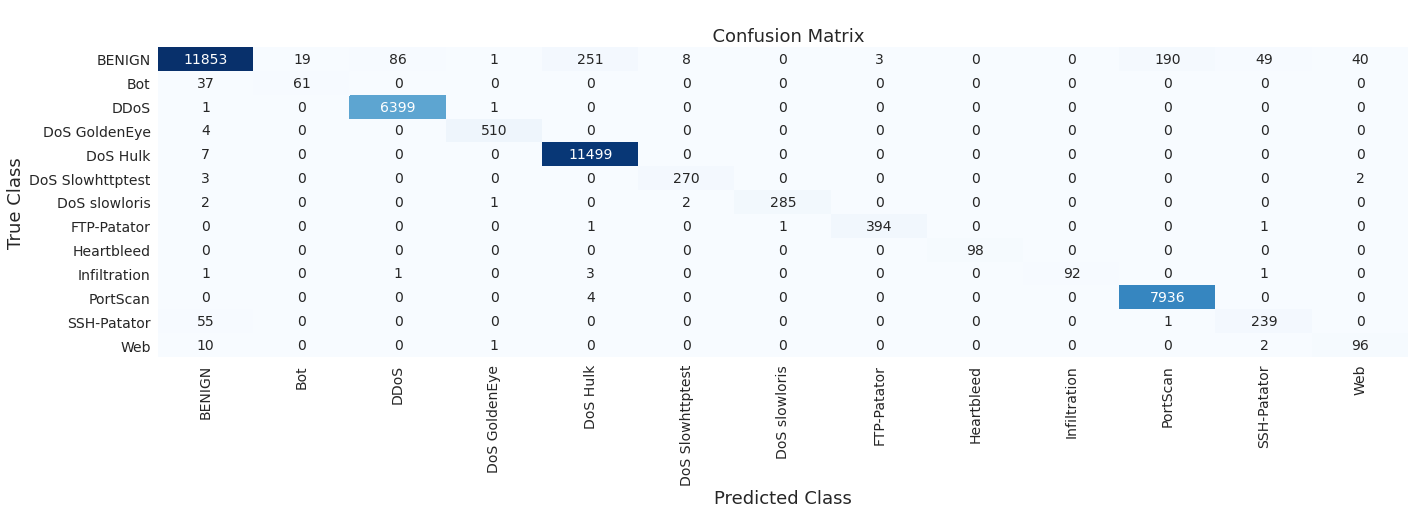

0.98053  | accuracy_score
0.93486  | balanced_accuracy_score
0.97458  | matthews_corrcoef
0.98053  | f1_score
0.98053  | recall_score
0.98053  | pecicion_score


In [12]:
activation = tf.nn.relu

model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(68,)),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(100, activation=activation),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(50, activation=activation),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(13, activation=tf.nn.softmax)])

clf = learning(learning_rate = 0.001, method = 'custom', epochs = 10, verbose = 1)
plot_loss_acc(clf[0], custom_LR = True, epochs = 10, save = False, val_line = False, name = '')

y_pred = np.argmax(clf[1].predict(X_test), axis = 1).reshape(-1,1)

confusion_matrix_plot(y_test, y_pred, save = False, path = '')

metrics_score(y_pred, y_test, average = 'micro')

**<center> NEURAL NETWORK OPTIMIZATION </center>**

Optimizations:

1. Scaler optimization
2. Hidden layers neuron optimization
3. Third layer checking
4. Optimization algorithm chosing
5. Activation Functions optimizing

In order to training time reducing, the model will be trained on a subset of the initial data

In [16]:
data, dataset = choose_dataset(1, path = '../Data/Data_Thesis/')

**Scaler optimization**

In [17]:
norm = {0: QuantileTransformer(),
        1: MinMaxScaler(),
        2: MaxAbsScaler(),
        3: StandardScaler(),
        4: RobustScaler(),
        5: PowerTransformer(),
        6: Normalizer()}

result_scalers = {'scaler1': [], 'scaler2': [], 'loss': [], 'val_loss': [], 'test_accuracy': []}

with tqdm(total = len(norm)**2) as pbar:
    for i in norm:
        for x in norm:
            if norm[i] == norm[x]:
                scaler = norm[i]
            else:
                scaler = Pipeline([('first', norm[i]), ('second', norm[x])])
            output = preprocessing(data = data, method = 'train_test_val', scaling_func = scaler, show_plots = False)
            locals().update(output)

            model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(68,)),
                                                tf.keras.layers.BatchNormalization(),
                                                tf.keras.layers.Dense(100, activation=activation),
                                                tf.keras.layers.BatchNormalization(),
                                                tf.keras.layers.Dense(50, activation=activation),
                                                tf.keras.layers.BatchNormalization(),
                                                tf.keras.layers.Dense(13, activation=tf.nn.softmax)])

            clf = learning(learning_rate = 0.001, method = 'custom', epochs = 15, verbose = False)

            y_pred = np.argmax(clf[1].predict(X_test), axis = 1).reshape(-1,1)

            result_scalers['loss'].append(clf[0]['loss'][-1][-1])
            result_scalers['val_loss'].append(clf[0]['val_loss'][-1][-1])
            result_scalers['test_accuracy'].append(accuracy_score(y_pred, y_test))
            result_scalers['scaler1'].append(norm[i])
            result_scalers['scaler2'].append(norm[x])

            pbar.update(1)

100%|██████████| 49/49 [36:53<00:00, 45.17s/it]


In [34]:
results1 = pd.DataFrame.from_dict(result_scalers)
results1.nsmallest(3, 'loss')

,scaler1,scaler2,loss,val_loss,test_accuracy
28,RobustScaler(),QuantileTransformer(),0.033335,0.045363,0.988343
2,QuantileTransformer(),MaxAbsScaler(),0.034378,0.042050,0.987510
14,MaxAbsScaler(),QuantileTransformer(),0.035102,0.043137,0.987094


Еhe best result was obtained by using
composition of scaler functions such as:

- Robust scaler
- Quantile transformer

Empirical risk result: **<font color=#CA4040>0.03335 </font>**

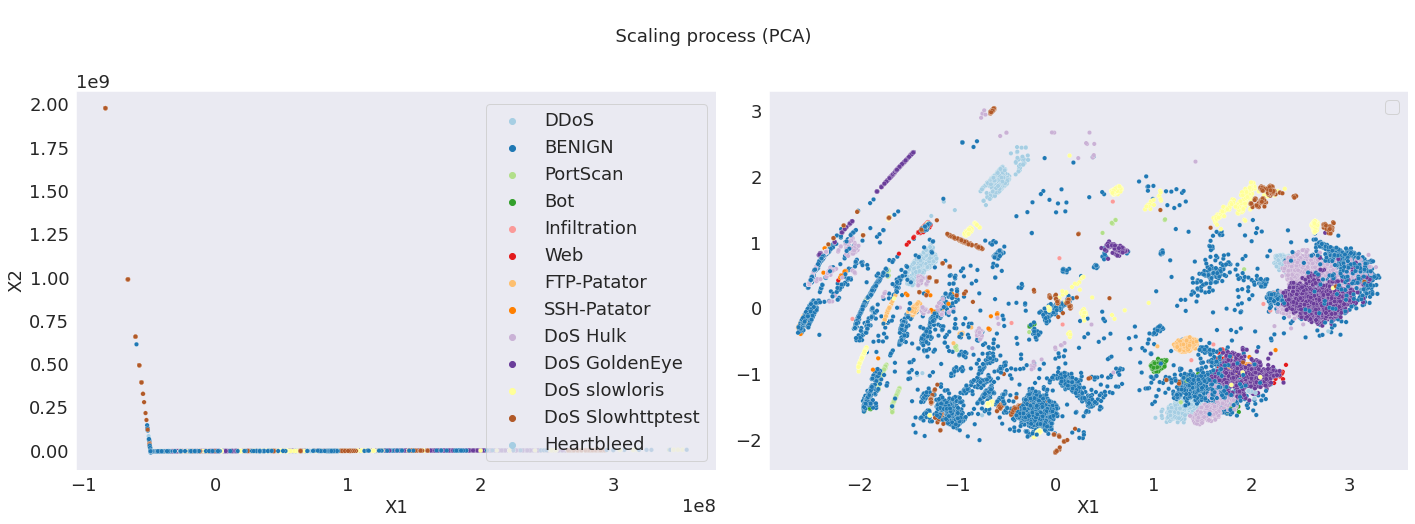

In [8]:
data, dataset = choose_dataset(1, path = '../Data/Data_Thesis/')
scaler = Pipeline([('first', RobustScaler()), ('second', QuantileTransformer())])
output = preprocessing(data = data, method = 'train_test_val', scaling_func = scaler, show_plots = 'scaling')

locals().update(output)

**Neurons Optimization**

In [44]:
grid = {'first' : np.arange(100, 230, 10),
        'second': np.arange(100, 230, 10)}

results_two_hidden = {'loss': [], 'val_loss': [], 'accuracy': [], 'first' : [], 'second': []}

with tqdm(total = len(grid['first']) * len(grid['second'])) as pbar:
    for i in grid['first']:
        for j in grid['second']:

            model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(68,)),
                                                tf.keras.layers.BatchNormalization(),
                                                tf.keras.layers.Dense(i, activation=tf.nn.relu),
                                                tf.keras.layers.BatchNormalization(),
                                                tf.keras.layers.Dense(j, activation=tf.nn.relu),
                                                tf.keras.layers.BatchNormalization(),
                                                tf.keras.layers.Dense(13, activation=tf.nn.softmax)])

            clf = learning(learning_rate = 0.001, method = 'custom', epochs = 15, verbose = False)

            y_pred = np.argmax(clf[1].predict(X_test), axis = 1).reshape(-1,1)

            results_two_hidden['first'].append(i)
            results_two_hidden['second'].append(j)
            results_two_hidden['loss'].append(clf[0]['loss'][-1][-1])
            results_two_hidden['val_loss'].append(clf[0]['val_loss'][-1][-1])
            results_two_hidden['accuracy'].append(accuracy_score(y_pred, y_test))

            pbar.update(1)
    

100%|██████████| 169/169 [2:14:40<00:00, 47.81s/it] 


In [58]:
results2 = pd.DataFrame.from_dict(results_two_hidden)
results2.nsmallest(4, 'loss')

,loss,val_loss,accuracy,first,second
142,0.025557,0.035458,0.990841,200,220
155,0.025751,0.038358,0.991257,210,220
111,0.025850,0.036196,0.990008,180,170
97,0.025914,0.039806,0.990008,170,160


The best result was obtained by using 200 neurons on the first layer and 220 neurons on the second layer of the neural network.

Empirical risk result: **<font color=#CA4040>0.025557</font>**

Third (second) hidden layer checking

In [59]:
grid = {'second_layer': np.arange(200, 300, 5)}

results_middle_layer = {'loss': [], 'val_loss': [], 'accuracy': [], 'second_layer' : []}

for i in tqdm(grid['second_layer']):
    model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(68,)),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dense(200, activation=activation),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dense(i, activation=activation),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dense(220, activation=activation),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dense(13, activation=tf.nn.softmax)])

    clf = learning(learning_rate = 0.001, method = 'custom', epochs = 15, class_weights = None, verbose = False)
    y_pred = np.argmax(clf[1].predict(X_test), axis = 1).reshape(-1,1)

    results_middle_layer['second_layer'].append(i)
    results_middle_layer['loss'].append(clf[0]['loss'][-1][-1])
    results_middle_layer['val_loss'].append(clf[0]['val_loss'][-1][-1])
    results_middle_layer['accuracy'].append(accuracy_score(y_pred, y_test))


100%|██████████| 20/20 [25:13<00:00, 75.66s/it]


In [60]:
results3 = pd.DataFrame.from_dict(results_middle_layer)
results3.nsmallest(3, 'loss')

,loss,val_loss,accuracy,second_layer
19,0.021197,0.035329,0.991674,295
16,0.021274,0.035713,0.992090,280
14,0.021290,0.036061,0.990841,270


The best result was obtained by using 295 neurons on the second layer of the neural network.

Empirical risk result: **<font color=#CA4040>0.021197</font>**

Optimizer Choosing

In [61]:
grid = {'optimizers': [tf.keras.optimizers.Adam(),
                       tf.keras.optimizers.SGD(),
                       tf.keras.optimizers.RMSprop(),
                       tf.keras.optimizers.Adadelta(),
                       tf.keras.optimizers.Adagrad(),
                       tf.keras.optimizers.Adamax(),
                       tf.keras.optimizers.Nadam()],
        'learning_rate' : [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]}

results_optimizers = {'loss': [], 'val_loss': [], 'accuracy': [], 'optimizer' : [], 'learning_rate': []}

with tqdm(total = len(grid['optimizers']) * len(grid['learning_rate'])) as pbar:
    for i in grid['optimizers']:
        for j in grid['learning_rate']:

            model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(68,)),
                                                tf.keras.layers.BatchNormalization(),
                                                tf.keras.layers.Dense(200, activation=activation),
                                                tf.keras.layers.BatchNormalization(),
                                                tf.keras.layers.Dense(295, activation=activation),
                                                tf.keras.layers.BatchNormalization(),
                                                tf.keras.layers.Dense(220, activation=activation),
                                                tf.keras.layers.BatchNormalization(),
                                                tf.keras.layers.Dense(13, activation=tf.nn.softmax)])

            clf = learning(learning_rate = j, optimizer = i, method = 'custom', epochs = 15, class_weights = None, verbose = False)

            y_pred = np.argmax(clf[1].predict(X_test), axis = 1).reshape(-1,1)

            results_optimizers['optimizer'].append(str(i)[38:-26])
            results_optimizers['learning_rate'].append(j)
            results_optimizers['loss'].append(clf[0]['loss'][-1][-1])
            results_optimizers['val_loss'].append(clf[0]['val_loss'][-1][-1])
            results_optimizers['accuracy'].append(accuracy_score(y_pred, y_test))

            pbar.update(1)

100%|██████████| 42/42 [59:28<00:00, 84.97s/it] 


In [63]:
results4 = pd.DataFrame.from_dict(results_optimizers)
results4.nsmallest(5, 'loss')

,loss,val_loss,accuracy,optimizer,learning_rate
15,0.018399,0.033695,0.992506,rmsprop.RMSprop,0.001
14,0.018978,0.036838,0.991674,rmsprop.RMSprop,0.005
39,0.019670,0.036471,0.992090,nadam.Nadam,0.001
31,0.019673,0.033521,0.992923,adamax.Adamax,0.010
13,0.020268,0.040017,0.991674,rmsprop.RMSprop,0.010


The best result was obtained by using RMSprop optimizer. The next best optimizer Nadam will also be tested on the full set of data

Empirical risk result: **<font color=#CA4040>0.018399</font>**

Activation Function Choosing

In [10]:
grid = {'functions': [tf.nn.relu,
                      tf.nn.elu,
                      tf.nn.leaky_relu,
                      tf.nn.softplus,
                      tf.nn.crelu,
                      tf.nn.swish,
                      tf.nn.tanh,
                      tf.nn.sigmoid,
                      tfa.activations.mish],
        'learning_rate': [0.0025, 0.001, 0.00075, 0.0005]}

results_activation_func = {'loss': [], 'val_loss': [], 'accuracy': [], 'activation_function' : [], 'learning_rate': []}

with tqdm(total = len(grid['functions']) * len(grid['learning_rate'])) as pbar:
    for lr in grid['learning_rate']:
        for i in grid['functions']:

            model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(68,)),
                                                tf.keras.layers.BatchNormalization(),
                                                tf.keras.layers.Dense(200, activation=i),
                                                tf.keras.layers.BatchNormalization(),
                                                tf.keras.layers.Dense(295, activation=i),
                                                tf.keras.layers.BatchNormalization(),
                                                tf.keras.layers.Dense(220, activation=i),
                                                tf.keras.layers.BatchNormalization(),
                                                tf.keras.layers.Dense(13, activation=tf.nn.softmax)])

            clf = learning(learning_rate = lr, optimizer = tf.keras.optimizers.RMSprop(), method = 'custom', epochs = 15, class_weights = None, verbose = False)
        
            y_pred = np.argmax(clf[1].predict(X_test), axis = 1).reshape(-1,1)

            results_activation_func['activation_function'].append(str(i)[10::-19])
            results_activation_func['learning_rate'].append(lr)
            results_activation_func['loss'].append(clf[0]['loss'][-1][-1])
            results_activation_func['val_loss'].append(clf[0]['val_loss'][-1][-1])
            results_activation_func['accuracy'].append(accuracy_score(y_pred, y_test))

            pbar.update(1)

 22%|██▏       | 8/36 [14:24<49:19, 105.70s/it]  /usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/resource_loader.py:72: UserWarning: You are currently using TensorFlow 2.3.1 and trying to load a custom op (custom_ops/activations/_activation_ops.so).
TensorFlow Addons has compiled its custom ops against TensorFlow 2.2.0, and there are no compatibility guarantees between the two versions. 
This means that you might get segfaults when loading the custom op, or other kind of low-level errors.
 If you do, do not file an issue on Github. This is a known limitation.

It might help you to fallback to pure Python ops with TF_ADDONS_PY_OPS . To do that, see https://github.com/tensorflow/addons#gpucpu-custom-ops 

You can also change the TensorFlow version installed on your system. You would need a TensorFlow version equal to or above 2.2.0 and strictly below 2.3.0.
 Note that nightly versions of TensorFlow, as well as non-pip TensorFlow like `conda install tensorflow` or compiled 

In [19]:
results5 = pd.DataFrame.from_dict(results_activation_func)
results5.nsmallest(5, 'loss')

,loss,val_loss,accuracy,activation_function,learning_rate
5,0.018563,0.037390,0.991257,swish,0.0025
13,0.018902,0.034567,0.992090,crelu_v2,0.0010
4,0.019049,0.037764,0.992090,crelu_v2,0.0025
0,0.019105,0.036065,0.992090,relu,0.0025
8,0.019127,0.034187,0.992506,mish,0.0025


The best result was obtained by using swish activation function. Optimizer's learning rate - 0.0025

Empirical risk result: **<font color=#CA4040>0.018563</font>**

**<center> FULL DATA TESTING ON AN OPTIMIZED NEURAL NETWORK </center>**

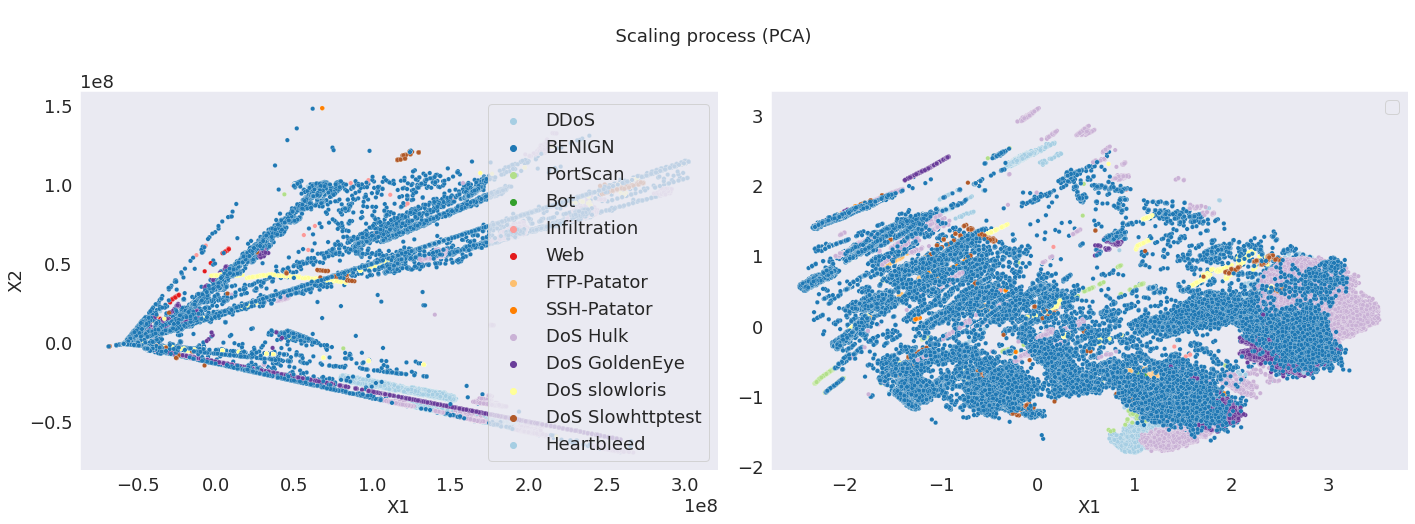

In [20]:
data, dataset = choose_dataset(2, path = '../Data/Data_Thesis/')
scaler = Pipeline([('first', RobustScaler()), ('second', QuantileTransformer())])
output = preprocessing(data = data, method = 'train_test_val', scaling_func = scaler, show_plots = 'scaling')

locals().update(output)

**RMSprop optimization algorithm testing**

In [31]:
activation = tf.nn.swish

model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(68,)),
                                                tf.keras.layers.BatchNormalization(),
                                                tf.keras.layers.Dense(200, activation=activation),
                                                tf.keras.layers.BatchNormalization(),
                                                tf.keras.layers.Dense(295, activation=activation),
                                                tf.keras.layers.BatchNormalization(),
                                                tf.keras.layers.Dense(220, activation=activation),
                                                tf.keras.layers.BatchNormalization(),
                                                tf.keras.layers.Dense(13, activation=tf.nn.softmax)])

clf = learning(learning_rate = 0.0025, optimizer = tf.keras.optimizers.RMSprop(), method = 'custom', epochs = 25, class_weights = None, verbose = 1)

Epoch 1/5
2850/2850 [==============================] - 118s 42ms/step - loss: 0.0456 - categorical_accuracy: 0.9854 - val_loss: 0.0241 - val_categorical_accuracy: 0.9922
Epoch 2/5
2850/2850 [==============================] - 118s 41ms/step - loss: 0.0216 - categorical_accuracy: 0.9934 - val_loss: 0.0143 - val_categorical_accuracy: 0.9961
Epoch 3/5
2850/2850 [==============================] - 116s 41ms/step - loss: 0.0171 - categorical_accuracy: 0.9951 - val_loss: 0.1181 - val_categorical_accuracy: 0.9619
Epoch 4/5
2850/2850 [==============================] - 106s 37ms/step - loss: 0.0150 - categorical_accuracy: 0.9958 - val_loss: 0.0125 - val_categorical_accuracy: 0.9974
Epoch 5/5
2850/2850 [==============================] - 106s 37ms/step - loss: 0.0139 - categorical_accuracy: 0.9961 - val_loss: 0.0203 - val_categorical_accuracy: 0.9954
Epoch 1/5
2850/2850 [==============================] - 106s 37ms/step - loss: 0.0089 - categorical_accuracy: 0.9975 - val_loss: 0.0081 - val_categoric

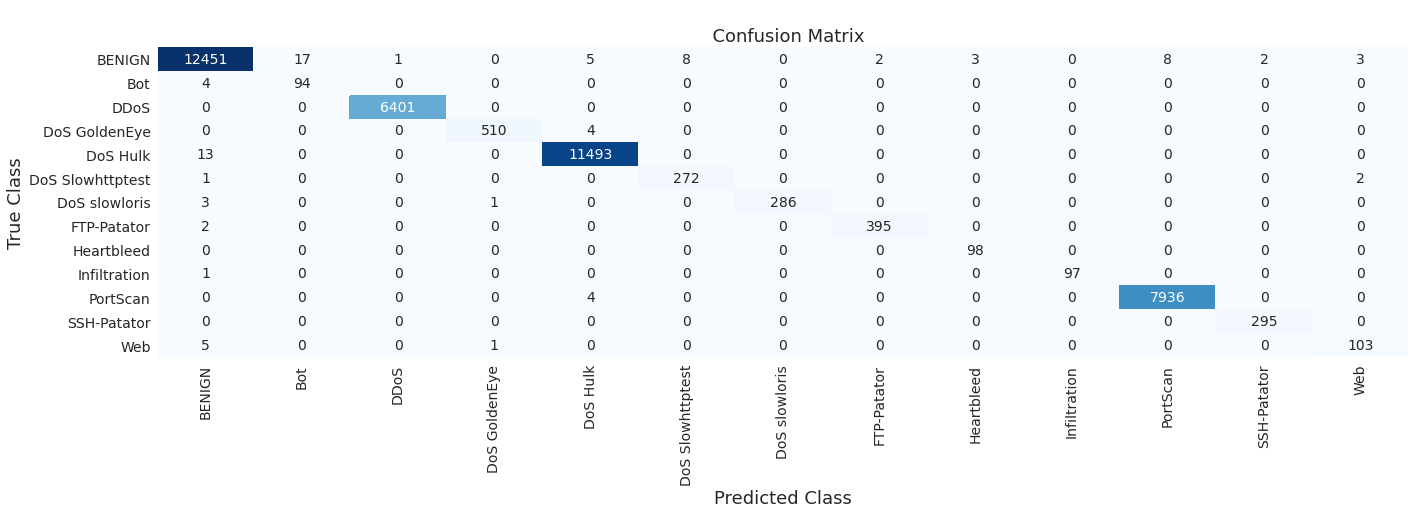

0.99778  | accuracy_score
0.97861  | balanced_accuracy_score
0.99708  | matthews_corrcoef
0.99778  | f1_score
0.99778  | recall_score
0.99778  | pecicion_score


In [32]:
y_pred = np.argmax(clf[1].predict(X_test), axis = 1).reshape(-1,1)

confusion_matrix_plot(y_test, y_pred, save = False, path = '')

metrics_score(y_pred, y_test, average = 'micro')

**Nadam optimization algorithm testing**

In [33]:
activation = tf.nn.swish

model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(68,)),
                                                tf.keras.layers.BatchNormalization(),
                                                tf.keras.layers.Dense(200, activation=activation),
                                                tf.keras.layers.BatchNormalization(),
                                                tf.keras.layers.Dense(295, activation=activation),
                                                tf.keras.layers.BatchNormalization(),
                                                tf.keras.layers.Dense(220, activation=activation),
                                                tf.keras.layers.BatchNormalization(),
                                                tf.keras.layers.Dense(13, activation=tf.nn.softmax)])

clf = learning(learning_rate = 0.001, optimizer = tf.keras.optimizers.Nadam(), method = 'custom', epochs = 25, class_weights = None, verbose = 1)

Epoch 1/5
2850/2850 [==============================] - 146s 51ms/step - loss: 0.0386 - categorical_accuracy: 0.9884 - val_loss: 0.0223 - val_categorical_accuracy: 0.9945
Epoch 2/5
2850/2850 [==============================] - 154s 54ms/step - loss: 0.0190 - categorical_accuracy: 0.9944 - val_loss: 0.0148 - val_categorical_accuracy: 0.9954
Epoch 3/5
2850/2850 [==============================] - 134s 47ms/step - loss: 0.0151 - categorical_accuracy: 0.9956 - val_loss: 0.0113 - val_categorical_accuracy: 0.9968
Epoch 4/5
2850/2850 [==============================] - 129s 45ms/step - loss: 0.0129 - categorical_accuracy: 0.9962 - val_loss: 0.0114 - val_categorical_accuracy: 0.9968
Epoch 5/5
2850/2850 [==============================] - 130s 46ms/step - loss: 0.0117 - categorical_accuracy: 0.9965 - val_loss: 0.1910 - val_categorical_accuracy: 0.9419
Epoch 1/5
2850/2850 [==============================] - 130s 46ms/step - loss: 0.0078 - categorical_accuracy: 0.9977 - val_loss: 0.0062 - val_categoric

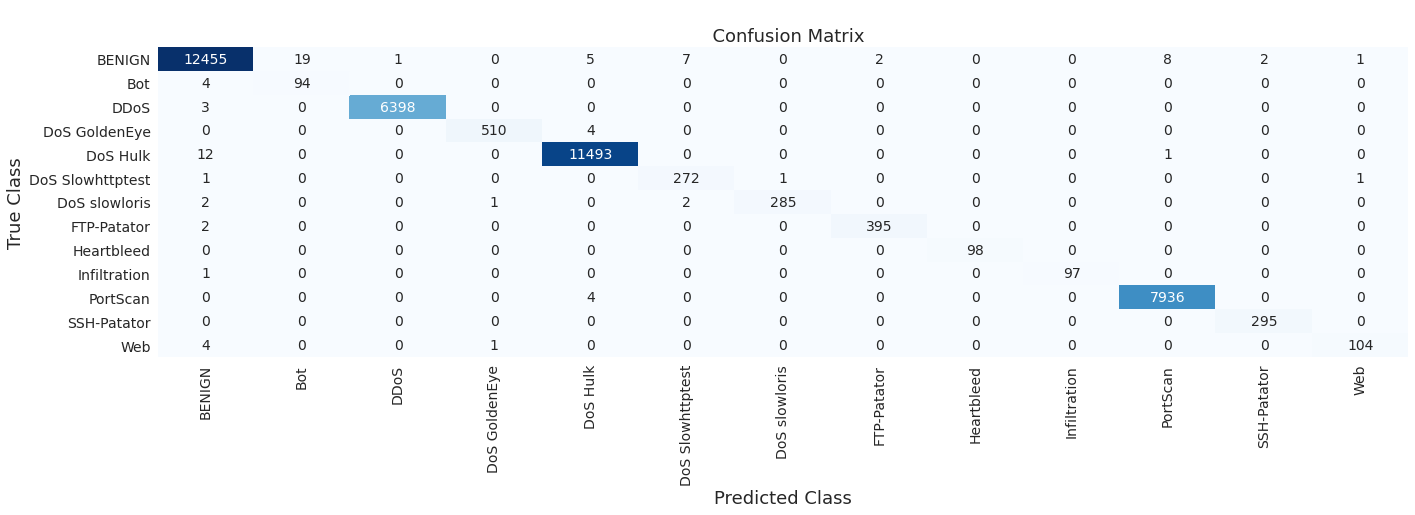

0.9978  | accuracy_score
0.98131  | balanced_accuracy_score
0.99711  | matthews_corrcoef
0.9978  | f1_score
0.9978  | recall_score
0.9978  | pecicion_score


In [44]:
y_pred = np.argmax(clf[1].predict(X_test), axis = 1).reshape(-1,1)

confusion_matrix_plot(y_test, y_pred, save = False)

metrics_score(y_pred, y_test, average = 'micro')

Eventually, the Nadam optimization algorithm has slightly better empirical risk result (**<font color=#CA4040>0.0056</font>** vs **<font color=#CA4040>0.0075</font>**) and so it has better metrics results 

In [45]:
clf[1].save_weights('model_weights.h5')

**<center> REAL WORLD DATA TESTING </center>**

In the first case some network data has been captured by sniffer software while surfing secure websites. It has been preprocessed and transformed to the tabular data type. 

In the second case, the data has been loaded from the NETRESEC database. This is unlabelled data, which is a collection of both infected traffic and normal traffic. The downloaded files were also preprocessed and transformed to the tabular data

**First case: captured data**

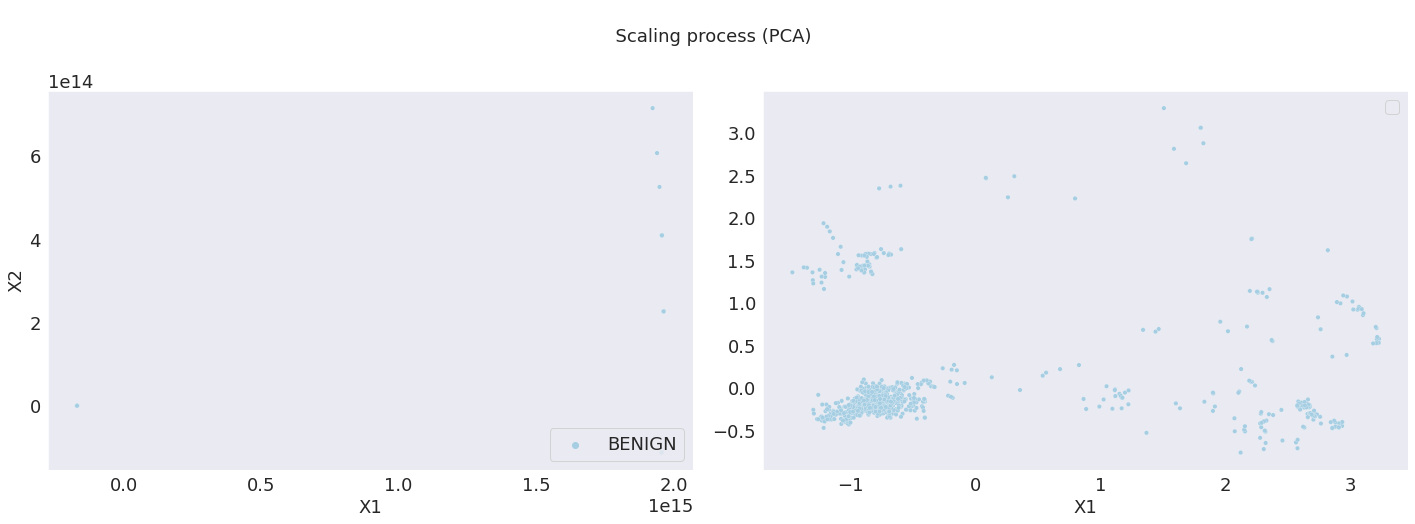

In [37]:
data, dataset = choose_dataset(4, path = '../Data/Data_Thesis/')

captured_data = preprocessing(data = data, method = 'test_manual_label', scaling_func = scaler, show_plots = True, label = 'BENIGN')
X_test_new, y_test_new = captured_data['X_test'], captured_data['y_test']

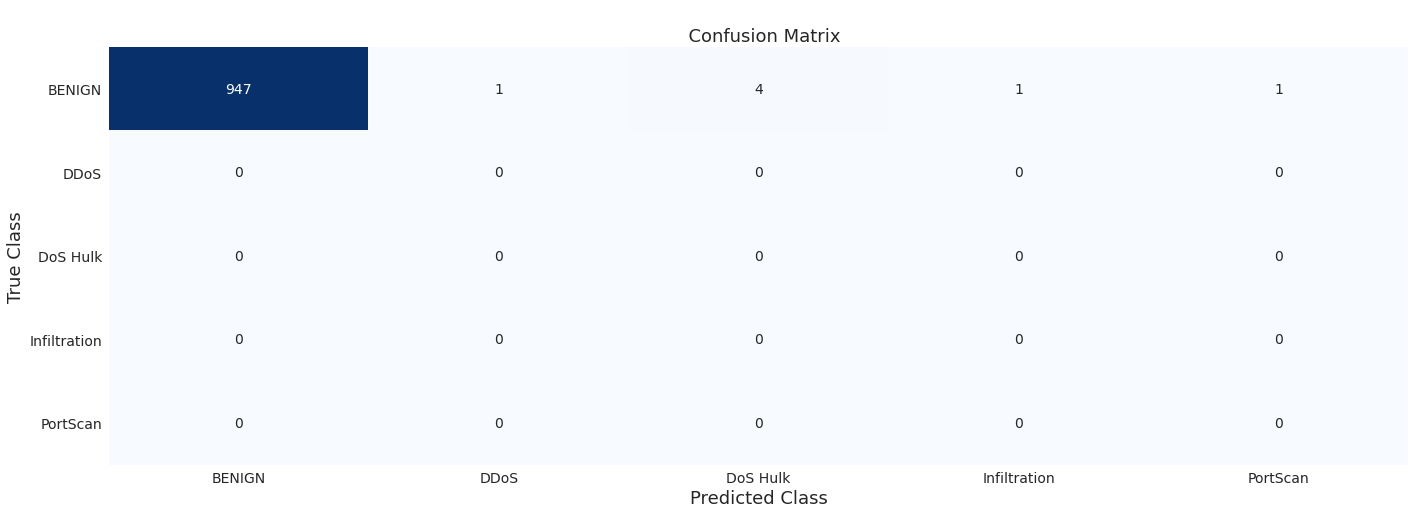

accuracy |  0.9926624737945493


In [47]:
final_model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(68,)),
                                                tf.keras.layers.BatchNormalization(),
                                                tf.keras.layers.Dense(200, activation=tf.nn.swish),
                                                tf.keras.layers.BatchNormalization(),
                                                tf.keras.layers.Dense(295, activation=tf.nn.swish),
                                                tf.keras.layers.BatchNormalization(),
                                                tf.keras.layers.Dense(220, activation=tf.nn.swish),
                                                tf.keras.layers.BatchNormalization(),
                                                tf.keras.layers.Dense(13, activation=tf.nn.softmax)])

final_model.load_weights('model_weights.h5')

y_pred_new = np.argmax(final_model.predict(X_test_new), axis = 1).reshape(-1,1)

confusion_matrix_plot(y_test_new, y_pred_new, save = False)

print('accuracy | ', accuracy_score(y_pred_new, y_test_new))

It can be considered as a great result, given that the model has not been trained on the new data before.

**Second case: NETRESEC data**

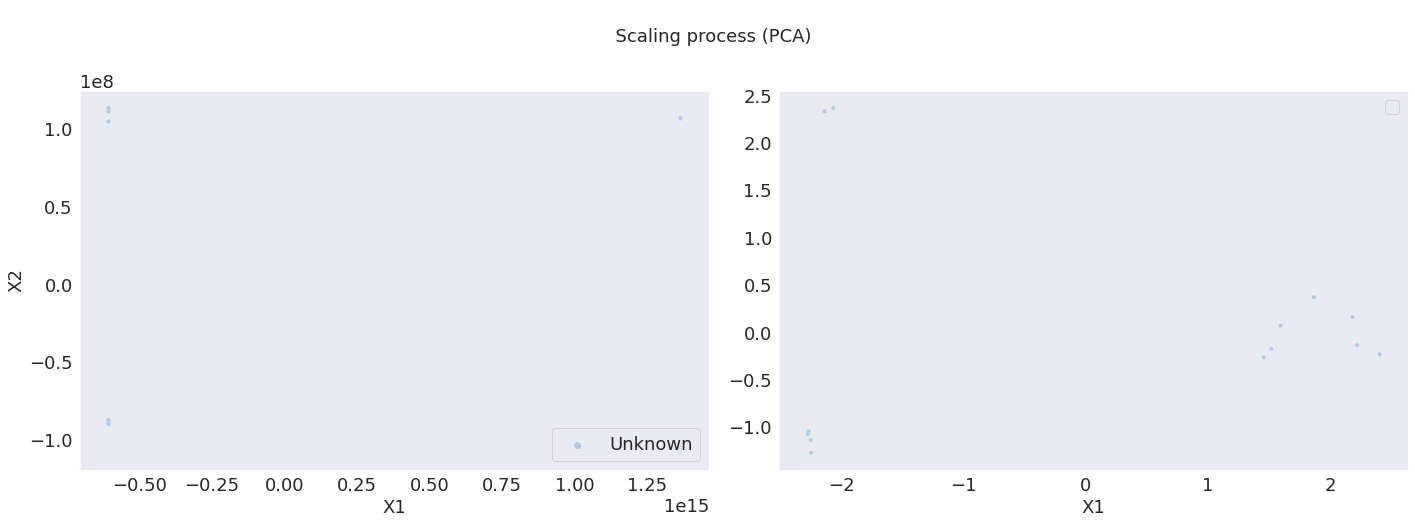

In [115]:
data, dataset = choose_dataset(5, path = '../Data/Data_Thesis/')

X_test_new2 = preprocessing(data = data, method = 'test', scaling_func = scaler, show_plots = True)['X_test']

In [116]:
y_pred_new = np.argmax(final_model.predict(X_test_new2), axis = 1).reshape(-1,1)

unique, counts = np.unique(LE.inverse_transform(y_pred_new.ravel()), return_counts=True)
print(np.asarray((unique, counts)).T)

[['BENIGN' 9]
 ['Infiltration' 1]
 ['PortScan' 3]]


In this case, it is not known how accurately the model classified the objects. It is also necessary to understand that only 12 classes of attacks were considered in the work, so the result of the prediction may not be accurate due to the lack of relevant data for 2021 year.

It also can be introdused as a flow-based system capable of detect the oblects in a real time process and compose reports. For example:

In [119]:
print('    ___________________  Scanning ___________________')
print()
for i in range(13):
    y_pred_new2 = np.argmax(final_model.predict(np.expand_dims(X_test_new2[i], axis=0)), axis = 1).reshape(-1,1)
    print('   ID:', i, '| Time:', datetime.now().strftime("%d/%m/%Y %H:%M:%S"), '| result:', LE.inverse_transform(y_pred_new2.ravel())[0]) 

    ___________________  Scanning ___________________

   ID: 0 | Time: 18/02/2021 16:51:27 | result: PortScan
   ID: 1 | Time: 18/02/2021 16:51:27 | result: BENIGN
   ID: 2 | Time: 18/02/2021 16:51:27 | result: Infiltration
   ID: 3 | Time: 18/02/2021 16:51:27 | result: BENIGN
   ID: 4 | Time: 18/02/2021 16:51:27 | result: BENIGN
   ID: 5 | Time: 18/02/2021 16:51:27 | result: PortScan
   ID: 6 | Time: 18/02/2021 16:51:27 | result: PortScan
   ID: 7 | Time: 18/02/2021 16:51:27 | result: BENIGN
   ID: 8 | Time: 18/02/2021 16:51:27 | result: BENIGN
   ID: 9 | Time: 18/02/2021 16:51:27 | result: BENIGN
   ID: 10 | Time: 18/02/2021 16:51:27 | result: BENIGN
   ID: 11 | Time: 18/02/2021 16:51:27 | result: BENIGN
   ID: 12 | Time: 18/02/2021 16:51:27 | result: BENIGN


The report can be generated as follows

In [163]:
def report(data, X_test, model):
    
    y_pred = np.argmax(model.predict(X_test), axis = 1).reshape(-1,1)
    y_pred = LE.inverse_transform(y_pred.ravel()).reshape(-1,1)
    data.Label = y_pred
    data = data[data.Label != 'BENIGN']
    return data[data.columns[np.r_[1:6, -1]]]

In [161]:
print(report(data = data, X_test = X_test_new2, model = final_model))

       Src IP  Src Port    Dst IP  Dst Port  Protocol         Label
0  10.3.2.101     51863  10.3.2.1        53        17      PortScan
2  10.3.2.101     60227  10.3.2.1        53        17  Infiltration
5  10.3.2.101     61611  10.3.2.1        53        17      PortScan
6  10.3.2.101     53501  10.3.2.1        53        17      PortScan
